In [1]:
# %load_ext tensorboard
import random
import warnings
from copy import deepcopy
from functools import partial
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from src.dataset_handler.classic_dataset import ClassicDataset
from src.models.lightning_wrapper import LightningWrapper
from src.models.multi_linear_layers import MultiLinearLayers
from src.neurons_importance import NeuronsImportance
from src.examples.utils_heart import preprocess_heart_data
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import BinaryAccuracy

warnings.simplefilter("ignore")

# TODO
Déceler les petits bugs restants, surtout en fin de traitement.

In [2]:
# %tensorboard --logdir ../lightning_logs/

In [3]:
checkpoints = '/home/lbaret/projects/explainability_sandbox/lightning_logs/version_1/checkpoints/epoch=99-step=9200.ckpt'

df_test = pd.read_csv('../data/test_heart.csv')
inputs, labels = df_test_prep = preprocess_heart_data(df_test)

In [4]:
test_set = ClassicDataset(inputs, labels)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

network = MultiLinearLayers(inputs.shape[1], 1)
loss_function = nn.BCEWithLogitsLoss()

model = LightningWrapper(network, loss_function, metrics={'accuracy': BinaryAccuracy().to('cuda')})
model.load_from_checkpoint(checkpoint_path=checkpoints)

LightningWrapper(
  (wrapped_model): MultiLinearLayers(
    (linear1): Linear(in_features=17, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=1, bias=True)
  )
  (loss_function): BCEWithLogitsLoss()
)

Bel entrainement maintenant, essayons de comprendre les distributions des neurones de chacune des couches, afin de savoir si c'est uniformément distribués où chaque neurone présente sa spécificité.

Récupérons le test set pour pouvoir commencer à travailler dessus. Un modèle simple + un cas binaire pour généraliser ensuite.

In [5]:
submodel = deepcopy(model.wrapped_model)
submodel.eval()

# Autant tout faire passer d'un coup
X_test = []
y_test = []
for x, y in test_set:
    X_test.append(x.unsqueeze(0))
    y_test.append(y)

X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

# On peut chercher les logits du modèle
outputs = submodel(X_test)

BinaryAccuracy()(outputs, y_test.unsqueeze(1))

tensor(0.6667)

Super, maintenant entammons une analyse poussée de nos couches en sorties.

In [6]:
out_neurons_collector = {}
def forward_hook(module: nn.Module, inputs: torch.Tensor, outputs: torch.Tensor, name: str, out_neurons_collector: Dict[str, List[torch.Tensor]]) -> None:
    if name in out_neurons_collector.keys():
        out_neurons_collector[name].append(outputs.detach().cpu())
    else:
        out_neurons_collector[name] = [outputs.detach().cpu()]

hooks = []
for name, module in submodel.named_modules():
    if name != '':
        hooks.append(module.register_forward_hook(partial(forward_hook, name=name, out_neurons_collector=out_neurons_collector)))

outputs = submodel(X_test)

for h in hooks:
    h.remove()

for layer_name, neurons in out_neurons_collector.items():
    out_neurons_collector[layer_name] = deepcopy(torch.cat(out_neurons_collector[layer_name]))

In [7]:
out_neurons_collector['linear2'].mean(dim=0), out_neurons_collector['linear2'].std(dim=0)

(tensor([-0.0277,  0.0403,  0.0667,  ..., -0.0056,  0.0757, -0.0071]),
 tensor([0.0868, 0.1141, 0.1192,  ..., 0.0512, 0.1061, 0.1382]))

Avons nous à faire à des distributions normales ? Un test statistique pourra nous le dire !

In [8]:
normal_samples = {}
shapiro_pvalues = {}

for layer_name, layer_tensor in out_neurons_collector.items():
    normal_samples[layer_name] = []
    shapiro_pvalues[layer_name] = []

    for i in range(layer_tensor.shape[1]):
        samples = layer_tensor[:, i]
        shapiro_test = stats.shapiro(samples)

        normal_samples[layer_name].append(True if shapiro_test.pvalue > 0.05 else False)
        shapiro_pvalues[layer_name].append(shapiro_test.pvalue)

    normal_samples[layer_name] = torch.BoolTensor(normal_samples[layer_name])
    shapiro_pvalues[layer_name] = torch.Tensor(shapiro_pvalues[layer_name])

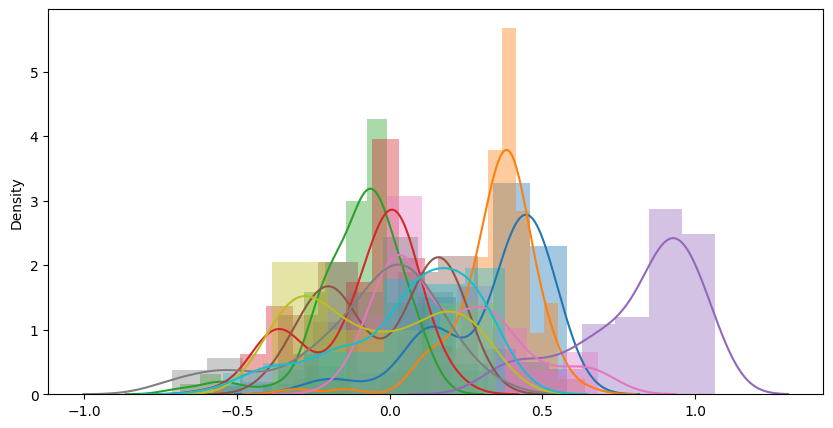

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

sorted_indices = shapiro_pvalues['linear1'].sort()[1][:10]
df_distplot = pd.DataFrame()
for c, ind in enumerate(sorted_indices):
    sns.distplot(out_neurons_collector['linear1'][:, ind.item()], ax=ax)

plt.show()

Souvent bimodal, c'est intéressant !

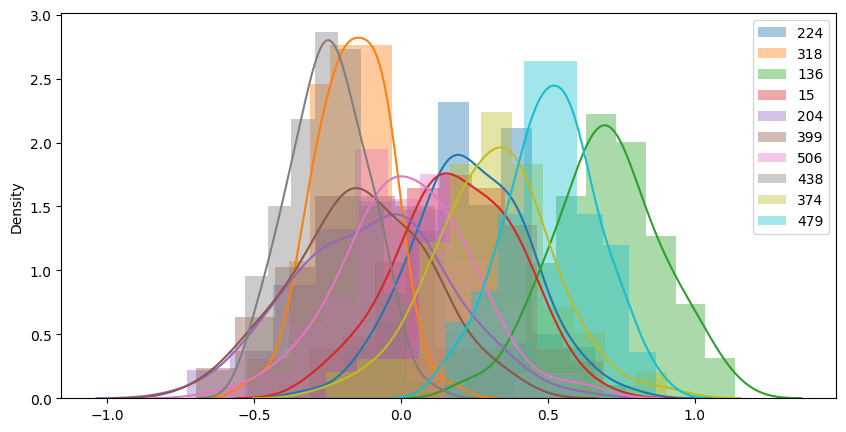

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

sorted_indices = shapiro_pvalues['linear1'].sort(descending=True)[1][:10]
df_distplot = pd.DataFrame()
for c, ind in enumerate(sorted_indices):
    sns.distplot(out_neurons_collector['linear1'][:, ind.item()], ax=ax, label=ind)

plt.legend()
plt.show()

Ont-ils simplement un effet régularisateur ?

Dans deux cas, où se situent les valeurs pour la classe 0 et la classe 1 ?

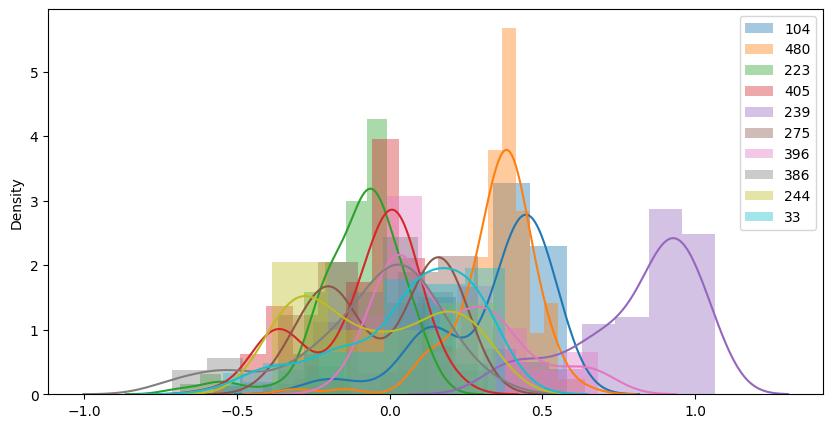

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

sorted_indices = shapiro_pvalues['linear1'].sort()[1][:10]
df_distplot = pd.DataFrame()
for c, ind in enumerate(sorted_indices):
    sns.distplot(out_neurons_collector['linear1'][:, ind.item()], ax=ax, label=ind)

plt.legend()
plt.show()

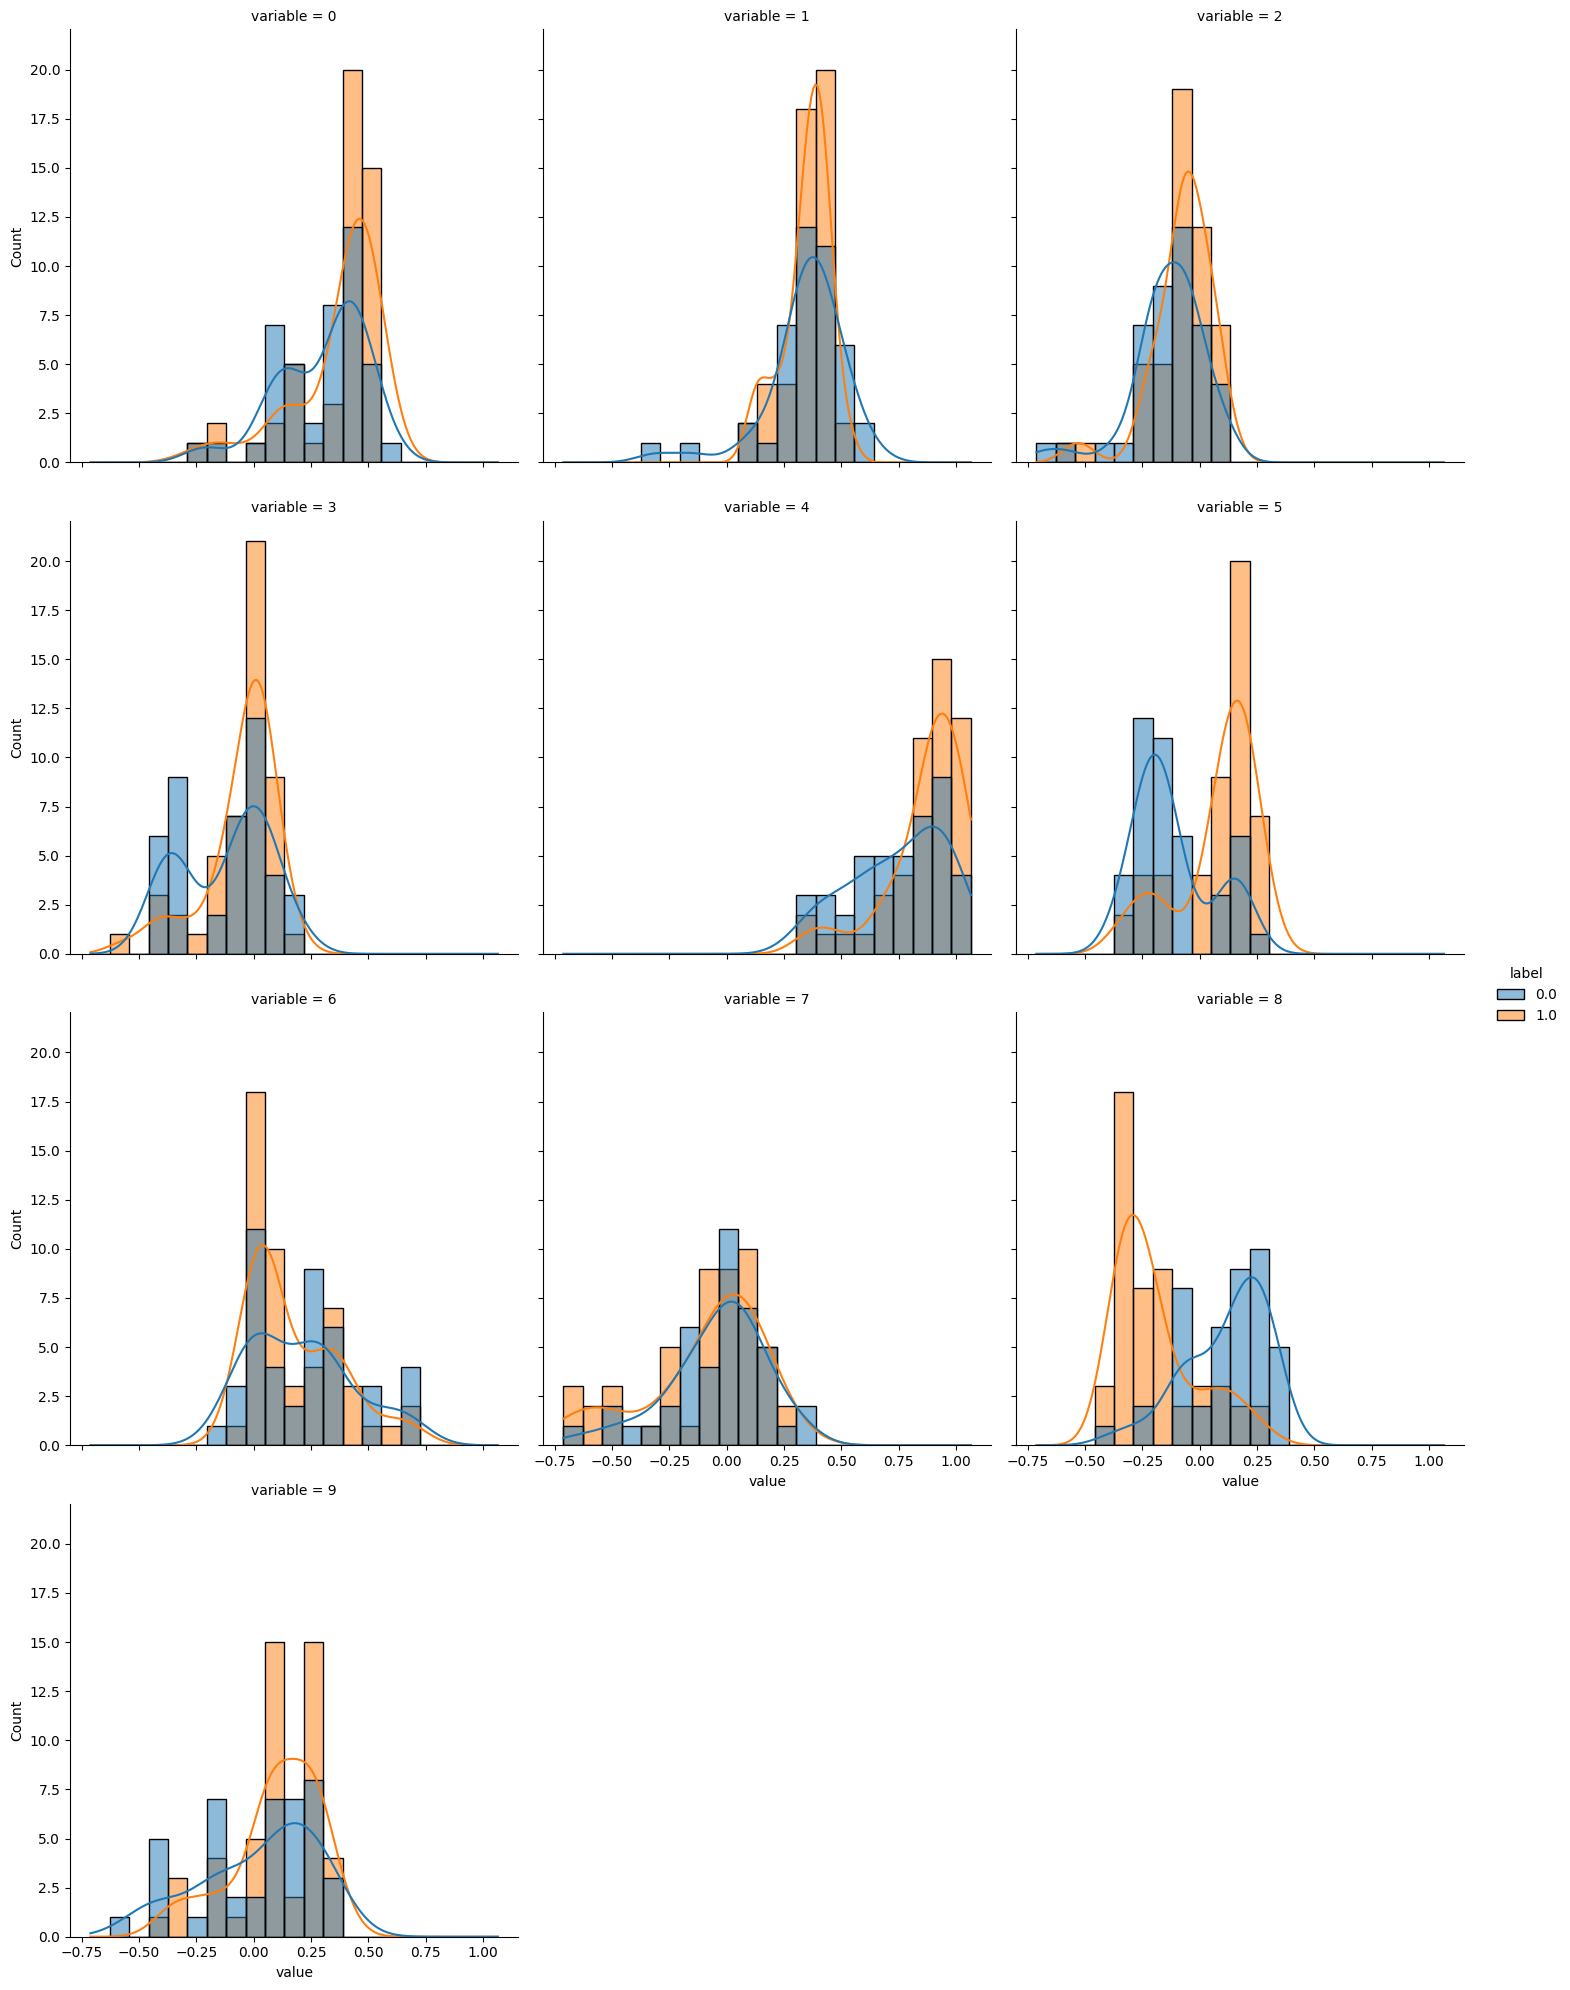

In [12]:
sorted_indices = shapiro_pvalues['linear1'].sort()[1][:10]

df_linear_1_unnormal = pd.DataFrame(data=out_neurons_collector['linear1'][:, sorted_indices])
df_linear_1_unnormal['label'] = y_test

sns.displot(data=df_linear_1_unnormal.melt(id_vars=['label']), x='value', hue='label', col='variable', col_wrap=3, alpha=0.5, kde=True);

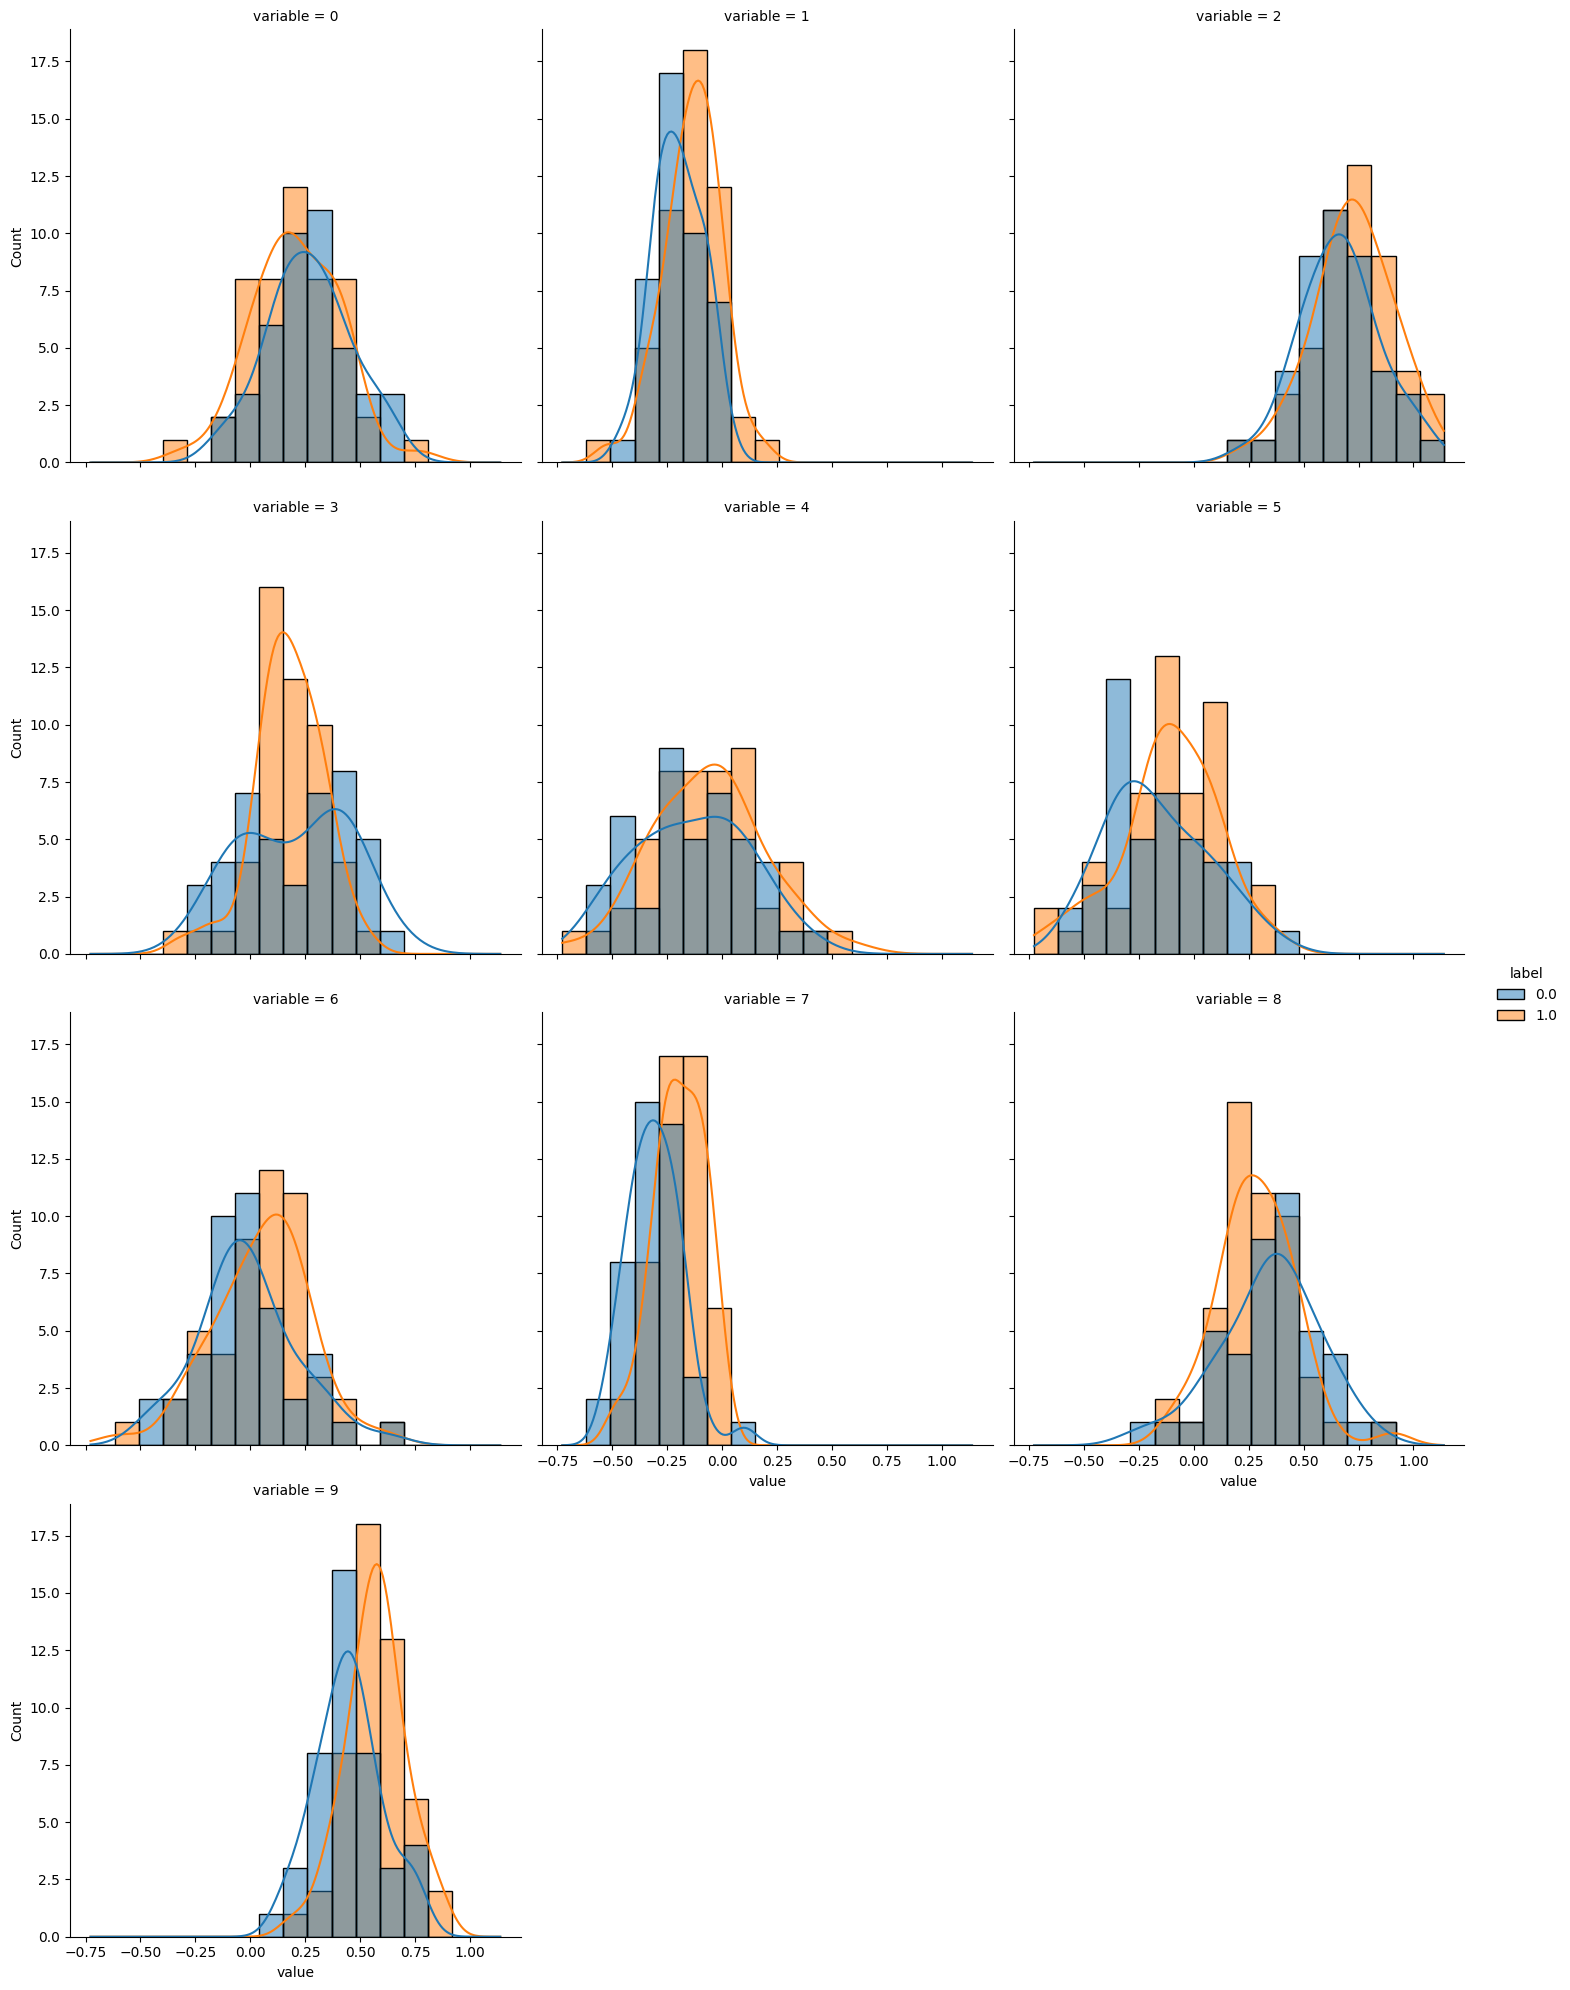

In [13]:
sorted_indices = shapiro_pvalues['linear1'].sort(descending=True)[1][:10]

df_linear_1_normal = pd.DataFrame(data=out_neurons_collector['linear1'][:, sorted_indices])
df_linear_1_normal['label'] = y_test

sns.displot(data=df_linear_1_normal.melt(id_vars=['label']), x='value', hue='label', col='variable', col_wrap=3, alpha=0.5, kde=True);

Admettons que nous avons des neurones que l'on considère comme dissociatifs, pouvons nous aisément repérer les poids ou l'ensemble des poids qui vont maintenir ou créer une dissociation par la suite ? \
Si les poids n'accentuent, ne conservent ou ne créent pas de dissociation alors ça va être difficile de repérer les neurones importants. \
Une de mes hypothèses est que les neurones dont les distributions sont confondues ne sont présents qu'à des fins de régulation et ne peuvent être considérés comme importants car non dissociés.

La question que nous pouvons nous poser maintenant est : quels sont les neurones qui présentent la plus grosse dissociation ? Que ce soit fortement positif ou négatif. Si présence de ReLU alors la négation est considérée comme nul et alors le signal qui est émit ne vient que d'une classe en soi.

Dans la méthode, nous ne pouvons négliger le théorème central limite, bien que nous ayons l'équivalent de 2 variables aléatoires par neurone (l'effet peut être plus remarquable avec plus de classes par exemple). L'union des deux distributions (de la classe 0 et de la classe 1) peut donner une distribution normale. Donc, il serait intéressant de mesurer 2 valeurs :
1. La divergence de *Kullback-Leibler* (sûrement le plus intéressant)
2. La moyenne et l'écart-type.

In [14]:
X1 = np.random.normal(loc=5.0, scale=1.5, size=(10000,))
X2 = np.random.normal(loc=5.0, scale=1.5, size=(1000,))
X3 = np.random.normal(loc=3.0, scale=1.0, size=(50,))
X4 = np.random.normal(loc=5.0, scale=2.0, size=(10000,))

stats.mannwhitneyu(X1, X2), stats.mannwhitneyu(X1, X3), stats.mannwhitneyu(X1, X4)

(MannwhitneyuResult(statistic=5001307.0, pvalue=0.9891129419358068),
 MannwhitneyuResult(statistic=439621.0, pvalue=1.934907063035832e-20),
 MannwhitneyuResult(statistic=49554907.0, pvalue=0.27561525087881866))

In [15]:
X_positive_1 = df_linear_1_normal[df_linear_1_normal['label'] == 1.][1].to_numpy()
X_negative_1 = df_linear_1_normal[df_linear_1_normal['label'] == 0.][1].to_numpy()

X_positive_9 = df_linear_1_normal[df_linear_1_normal['label'] == 1.][9].to_numpy()
X_negative_9 = df_linear_1_normal[df_linear_1_normal['label'] == 0.][9].to_numpy()

stats.mannwhitneyu(X_positive_1, X_negative_1), stats.mannwhitneyu(X_positive_9, X_negative_9)

(MannwhitneyuResult(statistic=1401.0, pvalue=0.012135530940406631),
 MannwhitneyuResult(statistic=1588.0, pvalue=7.843602909985048e-05))

Utilisons ce test statistique pour déterminer l'importance d'un neurone. Procédons par étapes :
1. Récupérons le dictionnaire des outputs d'une couche
2. Séparons les valeurs par rapport à leur classe
3. Effectuons les tests statistiques suivants :
   1. Si distributions normales ou proches : t-test (ou Student)
   2. Sinon : test de Mann-Whitney U
      1. Si semblables : cherchons voir si la moyenne/variance est similaire

In [16]:
negative_indices = torch.where(y_test == 0)[0]
positive_indices = torch.where(y_test == 1)[0]

layers_important_neurons = {}
layers_non_important_neurons = {}

for layer_name, layer_outputs in out_neurons_collector.items():
    if layer_name == 'fc':
        continue
    linear1 = out_neurons_collector['linear1']

    important_neurons = torch.zeros(size=(layer_outputs.shape[1],), dtype=torch.bool)

    for i in range(layer_outputs.shape[1]):
        samples = layer_outputs[:, i]
        important_neurons[i] = torch.BoolTensor([NeuronsImportance.neuron_is_important(samples, positive_indices, negative_indices)])[0]

    layers_important_neurons[layer_name] = torch.where(important_neurons == True)[0]
    layers_non_important_neurons[layer_name] = torch.where(important_neurons == False)[0]

Pour tester notre méthode, prenons aléatoirement et en répétant 10 fois, des neurones importants, effacons les (à 0) puis évaluons la perte en performance (faire pareil avec les neurones pas importants).

In [17]:
layers_important_neurons

{'linear1': tensor([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  12,  17,  18,  19,
          20,  21,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  34,  35,
          36,  38,  39,  42,  43,  44,  45,  47,  48,  49,  50,  52,  54,  55,
          57,  59,  60,  61,  63,  66,  68,  69,  70,  71,  72,  73,  74,  75,
          77,  78,  81,  84,  85,  86,  87,  88,  90,  91,  92,  93,  95,  96,
          97,  99, 100, 101, 103, 104, 105, 106, 108, 109, 111, 112, 115, 116,
         119, 120, 122, 123, 124, 125, 126, 128, 129, 131, 132, 133, 134, 137,
         139, 140, 144, 146, 147, 149, 150, 152, 153, 154, 155, 156, 158, 159,
         160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 173, 174, 176, 177,
         178, 179, 180, 181, 182, 183, 185, 186, 187, 189, 190, 191, 192, 193,
         194, 195, 196, 197, 198, 199, 201, 203, 205, 207, 208, 209, 210, 211,
         212, 213, 215, 216, 217, 220, 223, 228, 229, 230, 236, 237, 239, 241,
         242, 244, 245, 247, 249, 250, 25

Pour masquer les neurones il faut masquer tous les poids et biais arrivant à ce neurone. Ce faisant nous empêchons tout signal d'arriver jusqu'à ce neurone et donc il ne sera pas utile pour la suite des traitements.

Cependant ce qu'il faut prendre en compte, c'est que cette méthode statistique ne permet pas de prendre en compte toutes les interactions entre les neurones des couches successives. Donc éteindre le signal provenant d'un neurone peut avoir une conséquence dans la couche suivante. Il faut donc trouver une amélioration à cette méthode.

In [18]:
important_masked_accuracy = []
non_important_masked_accuracy = []
for _ in range(10):
    important_masked_model = NeuronsImportance.mask_important_neurons(submodel, layers_important_neurons, percentage_masked=0.9)
    non_important_masked_model = NeuronsImportance.mask_important_neurons(submodel, layers_non_important_neurons, percentage_masked=0.9)

    important_outputs = important_masked_model(X_test)
    non_important_outputs = non_important_masked_model(X_test)

    important_accuracy = BinaryAccuracy()(important_outputs, y_test.unsqueeze(1))
    non_important_accuracy = BinaryAccuracy()(non_important_outputs, y_test.unsqueeze(1))

    important_masked_accuracy.append(important_accuracy)
    non_important_masked_accuracy.append(non_important_accuracy)

In [19]:
important_masked_accuracy

[tensor(0.3118),
 tensor(0.4301),
 tensor(0.4624),
 tensor(0.4624),
 tensor(0.4409),
 tensor(0.4624),
 tensor(0.4946),
 tensor(0.6667),
 tensor(0.5054),
 tensor(0.4839)]

In [20]:
non_important_masked_accuracy

[tensor(0.5914),
 tensor(0.6344),
 tensor(0.6452),
 tensor(0.5806),
 tensor(0.5806),
 tensor(0.5806),
 tensor(0.5591),
 tensor(0.5591),
 tensor(0.5806),
 tensor(0.6667)]

Trouver un modèle plus gros, et commencer à réfléchir aux interactions !

Pour les interactions, je pense faire couche par couche afin de noter les changements de distribution d'une couche vers sa suivante, lorsque l'on désactive cette couche. Nous sommes donc dans le cas de la causalité à nous demander ce qu'il se passerait sur la couche suivante si on coupe le signal de la couche précédente.